In [1]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_acc(y_pred: np.ndarray, y: np.ndarray):
    return (y_pred == y).mean()

def get_per_class_acc():
    pass

## Utils

In [3]:
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    labels = []
    seed = np.random.randint(1000)
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.append(X[random_samples])
        labels.append(y[random_samples])
    
    data = np.concatenate(result)
    labels = np.concatenate(labels)
    np.random.seed(seed)
    np.random.shuffle(data)
    np.random.seed(seed)
    np.random.shuffle(labels)

    return data, labels

In [4]:
def get_corr_matrix(a, b, n_classes, self_corr_thresh=0.9):
    pd.DataFrame({'cluster': a, 'label': b})
    df = pd.DataFrame({i: a == i for i in range(n_classes)})
    for i in range(n_classes):
        df.iloc[np.where(b==i), i] = True

    corr = df.corr()
    corr.index = [chr(ord("@")+i+1) for i in range(n_classes)]
    adjusted_corr = corr - np.eye(*corr.shape) * self_corr_thresh
    adjusted_corr.index.name = 'Cluster'
    adjusted_corr.columns.name = 'label'

    return adjusted_corr

In [5]:
def draw_confusion_matrices(y_test, cluster_preds, corr_cluster_assigns, majority_cluster_assigns):
    fig, axes = plt.subplots(1,2, figsize=(18,6))

    for j, metric in enumerate([corr_cluster_assigns, majority_cluster_assigns]):
        y_pred = np.array([metric[chr(ord("@")+i+1)] for i in cluster_preds])
        sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, fmt='.1%', cbar=False, ax=axes[j])
        plt.suptitle('Confusion matrix', size=15, x=0.51, y=0.95)
        axes[j].set_title(f'{"Majority" if j else "Correlation"} method - accuracy: {get_acc(y_pred, y_test):.2%}', size=11);

In [6]:
def plot_clusters(X, lables, title, n_classes=10, n=4000):
    _, ax = plt.subplots(figsize=(13,8))

    for digit in range(n_classes):
        ax.scatter(
            *X[lables == digit][:n].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.tab10(digit),
            alpha=0.4,
            zorder=2,
        )
    ax.set_title(title, size=16)
    ax.axis("off");

## Part 0: Load the data

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
flat_X_train, flat_X_test = (X.reshape(X.shape[0], -1) for X in (X_train, X_test))
n_classes = len(np.unique(y_train))
n_samples = X_train.shape[0]

Normalize using min-max normalization

In [8]:
flat_X_test = flat_X_test / 255
flat_X_train = flat_X_train / 255

2. Explore the MNIST dataset

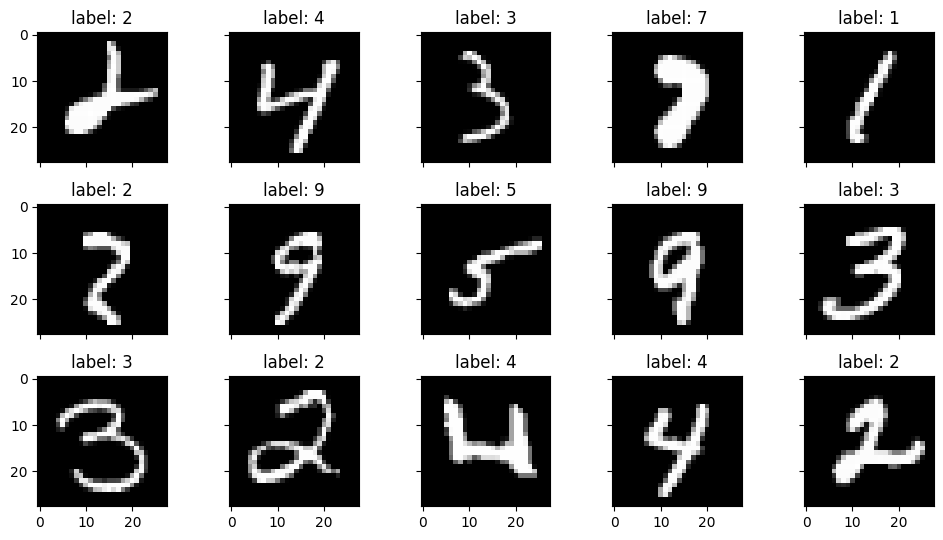

In [118]:
samples_shape = (3,5)

fig, ax = plt.subplots(*samples_shape, sharey=True, sharex=True, figsize=(10,5.5))
idxes = np.random.randint(len(X_train), size=samples_shape)
for i in range(samples_shape[0]):
    for j in range(samples_shape[1]):
        idx = idxes[i,j]
        image, label = X_train[idx], y_train[idx]
        ax[i,j].imshow(image, cmap=plt.cm.binary_r)
        ax[i,j].set_title(f'label: {label}')
plt.tight_layout()

In [119]:
train_df = pd.DataFrame(y_train, columns=['class_int'])
test_df = pd.DataFrame(y_test, columns=['class_int'])
train_df['train_samples'] = train_df['class_int']
test_df['test_samples'] = test_df['class_int']

counts_df = pd.concat([train_df['train_samples'].value_counts(), test_df['test_samples'].value_counts()], axis=1)
counts_df.loc['total'] = counts_df.sum()
counts_df['total_samples'] = counts_df['train_samples'] + counts_df['test_samples']
counts_df.index = counts_df.index.astype(str)
counts_df.astype(int).sort_index()

train_samples  test_samples  total_samples
0               5923           980           6903
1               6742          1135           7877
2               5958          1032           6990
3               6131          1010           7141
4               5842           982           6824
5               5421           892           6313
6               5918           958           6876
7               6265          1028           7293
8               5851           974           6825
9               5949          1009           6958
total          60000         10000          70000

In [120]:
instance = X_train[0]
print(f'Every raw instance consists of {"x".join(map(str,instance.shape))}={np.prod(instance.shape)} pixels/features')

Every raw instance consists of 28x28=784 pixels/features


## Part 1: Clustering

### K means

In [9]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=n_classes)

In [10]:
k_means.fit(flat_X_train)

KMeans(n_clusters=10)

In [11]:
train_clustering = k_means.predict(flat_X_train)
k_means.inertia_

2352826.6553920396

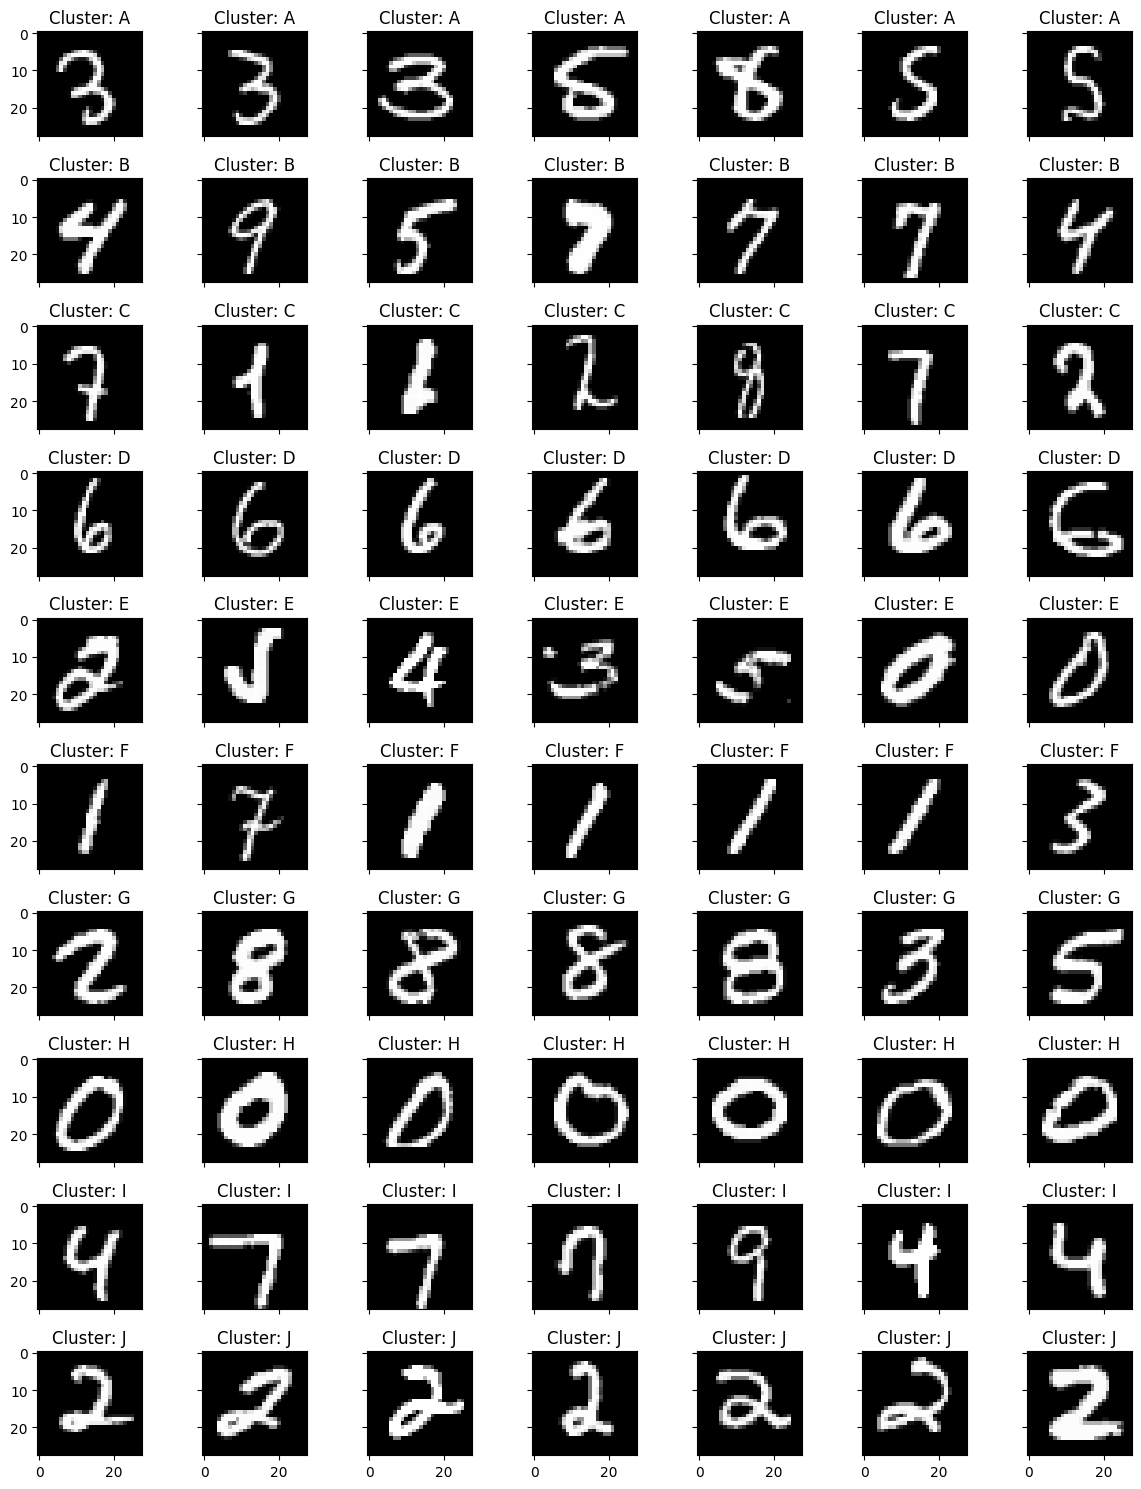

In [124]:
samples_shape = (n_classes,7)

fig, ax = plt.subplots(*samples_shape, sharey=True, sharex=True, figsize=(12,15))
for i in range(samples_shape[0]):
    cluster_images = X_train[train_clustering==i]
    cluster_labels = y_train[train_clustering==i]
    for j in range(samples_shape[1]):
        idx = np.random.randint(len(cluster_labels))
        image, label = cluster_images[idx], cluster_labels[idx]
        ax[i,j].imshow(image, cmap=plt.cm.binary_r)
        ax[i,j].set_title(f'Cluster: {chr(ord("@")+i+1)}')
plt.tight_layout()

Explanation - Check correlation between the clusters and labels. downgrade self correlations by 85% and assign label to cluster by max correlation

<AxesSubplot:xlabel='label', ylabel='Cluster'>

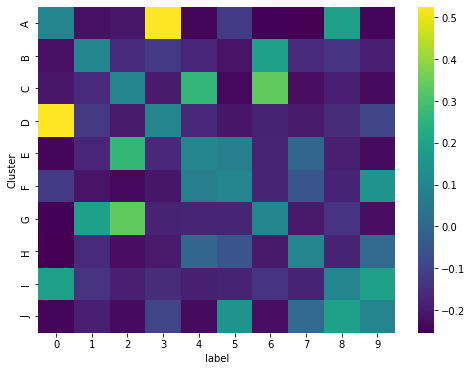

In [25]:
fig, ax = plt.subplots(figsize=(8,6)) 
corr = get_corr_matrix(train_clustering, y_train, n_classes)
sns.heatmap(corr, cmap='viridis')

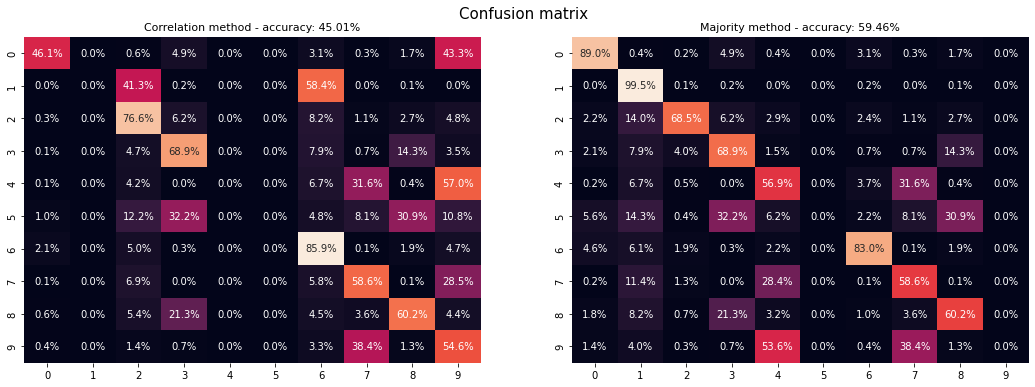

In [14]:
corr_cluster_assigns = corr.T.idxmax().to_dict()
majority_cluster_assigns = {chr(ord("@")+i+1): np.bincount(y_train[train_clustering==i]).argmax() for i in range(n_classes)}
cluster_preds = k_means.predict(flat_X_test)

draw_confusion_matrices(y_test, cluster_preds, corr_cluster_assigns, majority_cluster_assigns)

#### K means - Parameter experiment - self-corr threshold variation

In [127]:
accs = []
thresholds = np.linspace(0.5,1,51)
for thresh in np.linspace(0.5,1,51):
    adjusted_corr = get_corr_matrix(train_clustering, y_train, n_classes, thresh)
    corr_cluster_assigns = adjusted_corr.T.idxmax().to_dict()
    y_pred = np.array([corr_cluster_assigns[chr(ord("@")+i+1)] for i in cluster_preds])
    accs.append(get_acc(y_pred, y_test))

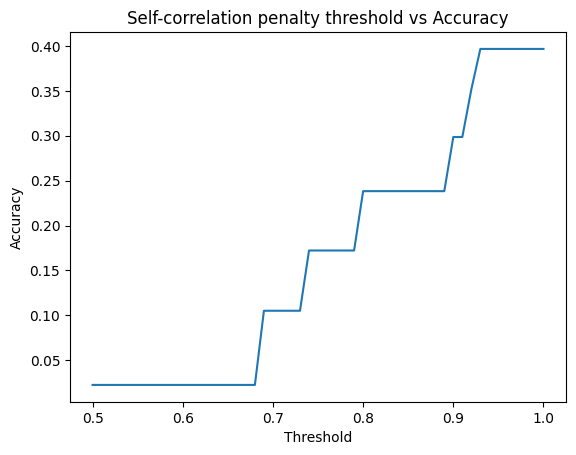

In [128]:
sns.lineplot(x=thresholds, y=accs)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Self-correlation penalty threshold vs Accuracy');

The following algorithms are more complex than k-means, thus we use only part of the data to fit the models. We use 400 samples from each label, having a total of 4000 training samples.

### Agglomerative Clustering

In [16]:
data, labels = sample(flat_X_train, y_train, samples=400)

In [130]:
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_classes)
agglomerative.fit(data)

AgglomerativeClustering(n_clusters=10)

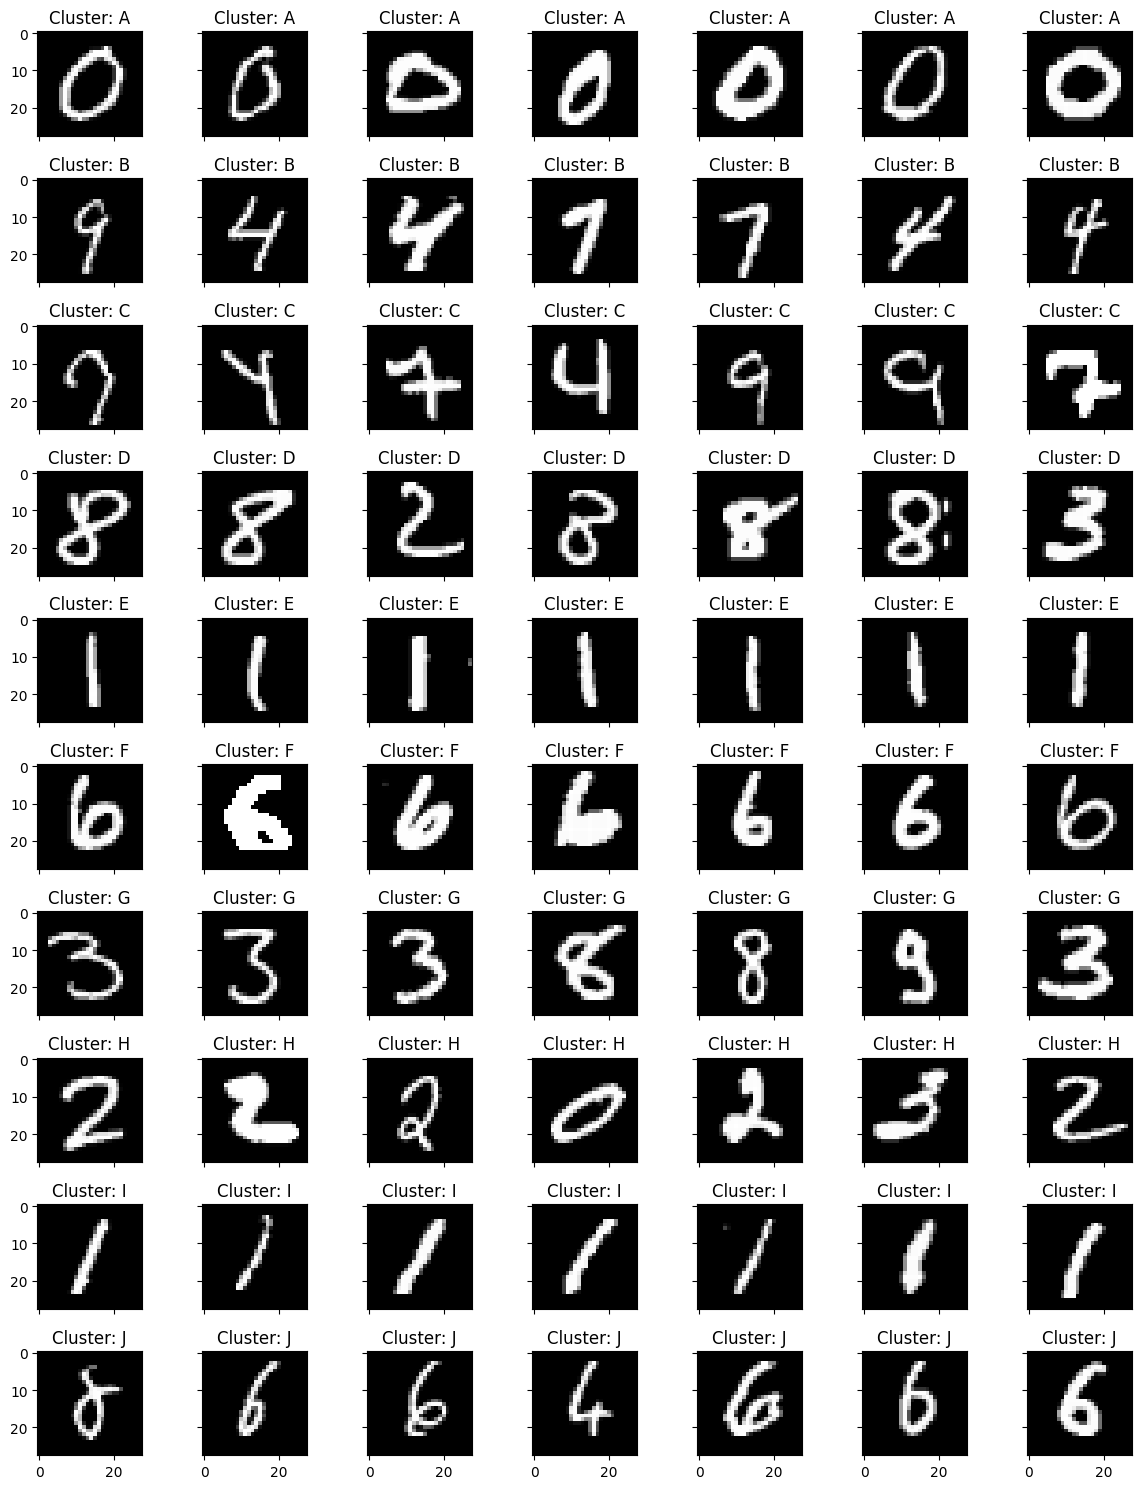

In [131]:
samples_shape = (n_classes,7)

fig, ax = plt.subplots(*samples_shape, sharey=True, sharex=True, figsize=(12,15))
for i in range(samples_shape[0]):
    cluster_images = data[agglomerative.labels_==i]
    cluster_labels = labels[agglomerative.labels_==i]
    for j in range(samples_shape[1]):
        idx = np.random.randint(len(cluster_labels))
        image, label = cluster_images[idx].reshape(28,-1), cluster_labels[idx]
        ax[i,j].imshow(image, cmap=plt.cm.binary_r)
        ax[i,j].set_title(f'Cluster: {chr(ord("@")+i+1)}')
plt.tight_layout()

In [132]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(1)
knn.fit(data, agglomerative.labels_)

KNeighborsClassifier(n_neighbors=1)

In [133]:
preds = knn.predict(flat_X_test)
corr = get_corr_matrix(agglomerative.labels_, labels, n_classes)

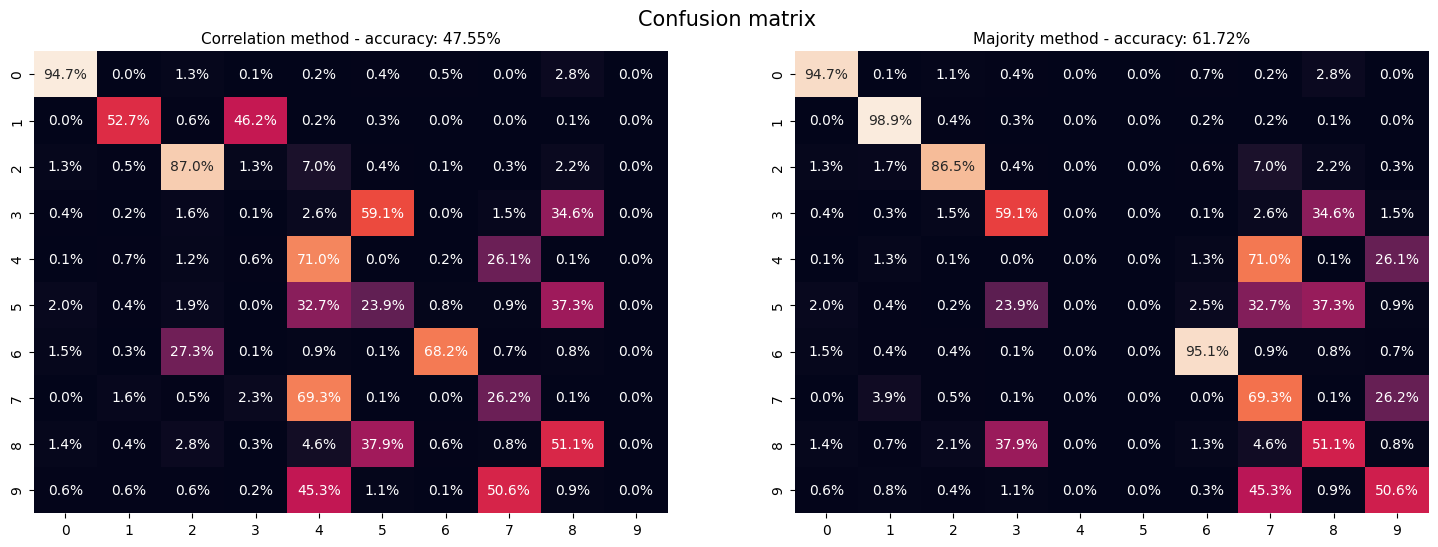

In [134]:
corr_cluster_assigns = corr.T.idxmax().to_dict()
majority_cluster_assigns = {chr(ord("@")+i+1): np.bincount(labels[agglomerative.labels_==i]).argmax() for i in range(n_classes)}

draw_confusion_matrices(y_test, preds, corr_cluster_assigns, majority_cluster_assigns)

#### Agglomerative Clustering - Experiments

We try different linkage methods

In [135]:
results = pd.DataFrame()
linkages = ['ward', 'complete', 'average', 'single']
for linkage in linkages:
    agglomerative = AgglomerativeClustering(n_classes, linkage=linkage)
    agglomerative.fit(data)
    preds = knn.predict(flat_X_test)
    corr = get_corr_matrix(agglomerative.labels_, labels, n_classes)
    corr_cluster_assigns = corr.T.idxmax().to_dict()
    majority_cluster_assigns = {chr(ord("@")+i+1): np.bincount(labels[agglomerative.labels_==i]).argmax() for i in range(n_classes)}

    y_pred_corr = np.array([corr_cluster_assigns[chr(ord("@")+i+1)] for i in preds])
    y_pred_maj = np.array([majority_cluster_assigns[chr(ord("@")+i+1)] for i in preds])
    corr_acc = get_acc(y_pred_corr, y_test)
    maj_acc = get_acc(y_pred_maj, y_test)
    results = pd.concat([results, pd.DataFrame({'Linkage': [linkage, linkage], 'Classification Method': ['corr', 'majority'], 'Accuracy': [corr_acc, maj_acc]})])
    

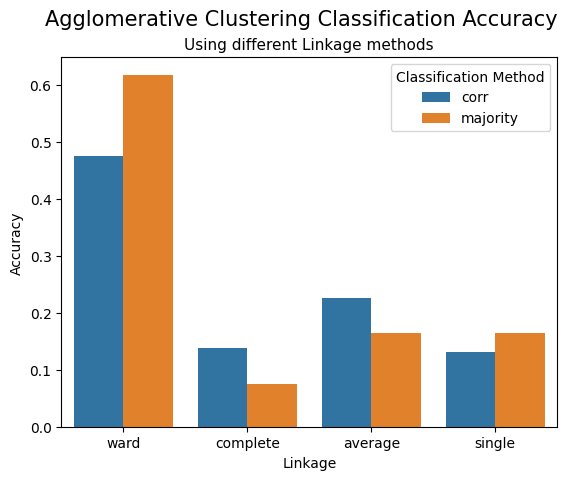

In [136]:
sns.barplot(x='Linkage', y='Accuracy', hue='Classification Method', data=results)
plt.suptitle('Agglomerative Clustering Classification Accuracy', size=15)
plt.title('Using different Linkage methods', size=11);

### GMM Clustering

In [17]:
from sklearn.mixture import GaussianMixture
GM_model = GaussianMixture(n_components=n_classes, covariance_type='spherical')
train_labels = GM_model.fit_predict(data)

In [18]:
corr = get_corr_matrix(train_labels, labels, n_classes)
corr_cluster_assigns = corr.T.idxmax().to_dict()
majority_cluster_assigns = {chr(ord("@")+i+1): np.bincount(labels[train_labels==i]).argmax() for i in range(n_classes)}

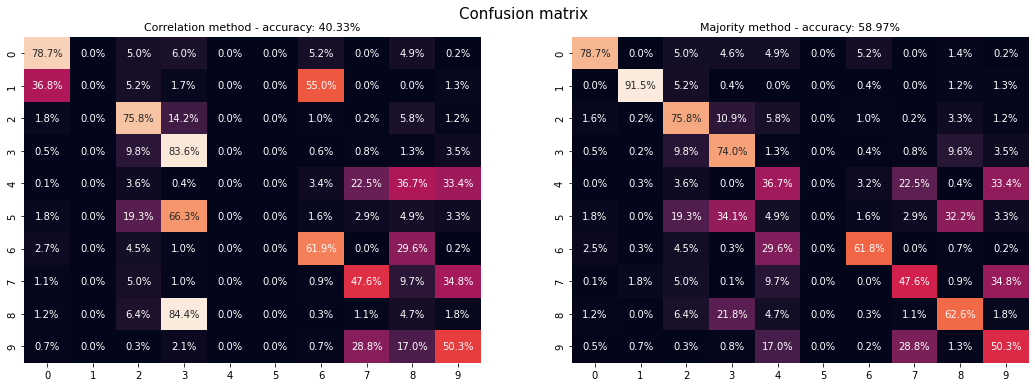

In [19]:
preds = GM_model.predict(flat_X_test)
draw_confusion_matrices(y_test, preds, corr_cluster_assigns, majority_cluster_assigns)

#### GMM - Experiments

We try different pixels cov matrix assumptions. Even though the pixel intensities are obviously correlated, best performance was achieved using a spherical cov matrix assumption. That is, assuming same variance for all pixels and no correlation between them.

In [20]:
cov_types = ['full', 'tied', 'diag', 'spherical']
results = pd.DataFrame()

for cov_type in cov_types:
    GM_model = GaussianMixture(n_components=n_classes, covariance_type=cov_type, n_init=3)
    train_labels = GM_model.fit_predict(data)
    corr = get_corr_matrix(train_labels, labels, n_classes)
    corr_cluster_assigns = corr.T.idxmax().to_dict()
    majority_cluster_assigns = {chr(ord("@")+i+1): np.bincount(labels[train_labels==i]).argmax() for i in range(n_classes)}
    preds = GM_model.predict(flat_X_test)
    y_pred_corr = np.array([corr_cluster_assigns[chr(ord("@")+i+1)] for i in preds])
    y_pred_maj = np.array([majority_cluster_assigns[chr(ord("@")+i+1)] for i in preds])
    corr_acc = get_acc(y_pred_corr, y_test)
    maj_acc = get_acc(y_pred_maj, y_test)
    results = pd.concat([results, pd.DataFrame({'Cov Type': [cov_type, cov_type], 'Classification Method': ['corr', 'majority'], 'Accuracy': [corr_acc, maj_acc]})])
    

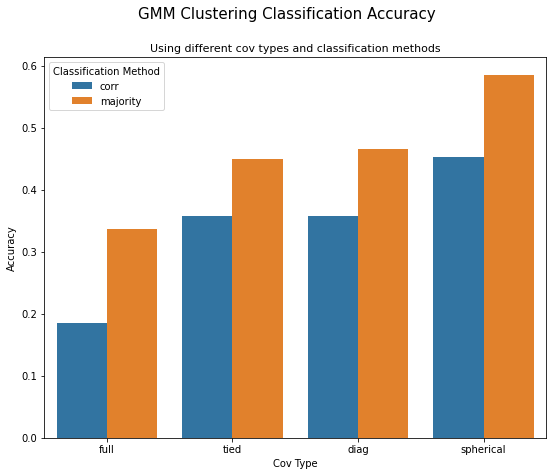

In [28]:
fig, ax = plt.subplots(figsize=(9,7)) 
sns.barplot(x='Cov Type', y='Accuracy', hue='Classification Method', data=results)
plt.suptitle('GMM Clustering Classification Accuracy', size=15)
plt.title('Using different cov types and classification methods', size=11);

## Part 2: Dimensionality Reduction

### PCA

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_x_train = pca.fit_transform(flat_X_train)
pca_X_test = pca.transform(flat_X_test)

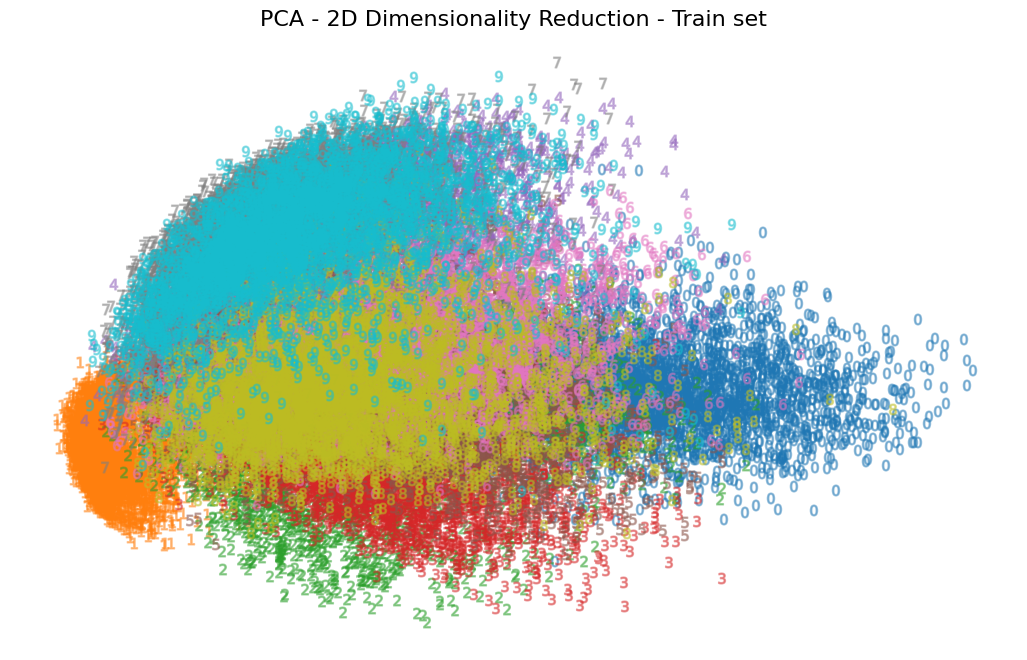

In [143]:
plot_clusters(pca_x_train, y_train, "PCA - 2D Dimensionality Reduction - Train set", n_classes=10)

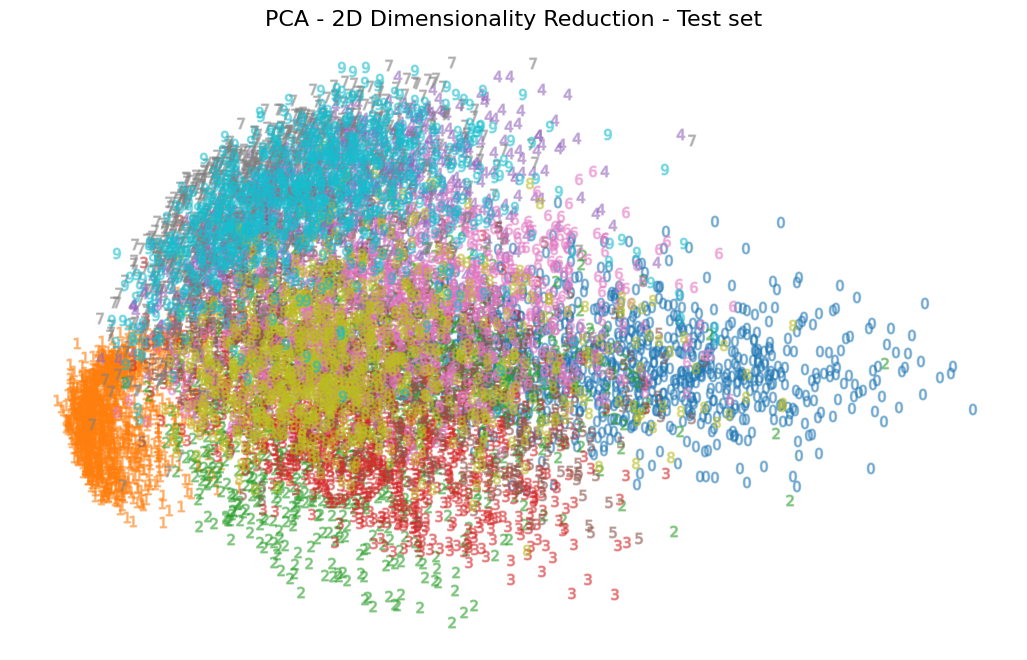

In [144]:
plot_clusters(pca_X_test, y_test, "PCA - 2D Dimensionality Reduction - Test set", n_classes=10)

In [145]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(pca_x_train, y_train)
pca_pred = knn.predict(pca_X_test)
print(f'Accuracy for PCA after Dimensionality Reduction: {get_acc(pca_pred, y_test):0.2%}')

Accuracy for PCA after Dimensionality Reduction: 40.43%


#### PCA - Experiment

In [146]:
n_components_lst = [2, 10, 20, 50, 100]
whiten_options = [True, False]
results  = {}
for n_components in n_components_lst:
    for whiten_option in whiten_options:
        pca = PCA(n_components=n_components, whiten=whiten_option)
        pca_X_train = pca.fit_transform(flat_X_train)
        pca_X_test = pca.transform(flat_X_test)
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(pca_X_train, y_train)
        pca_pred = knn.predict(pca_X_test)
        results[str((n_components, whiten_option))] = get_acc(pca_pred, y_test)*100

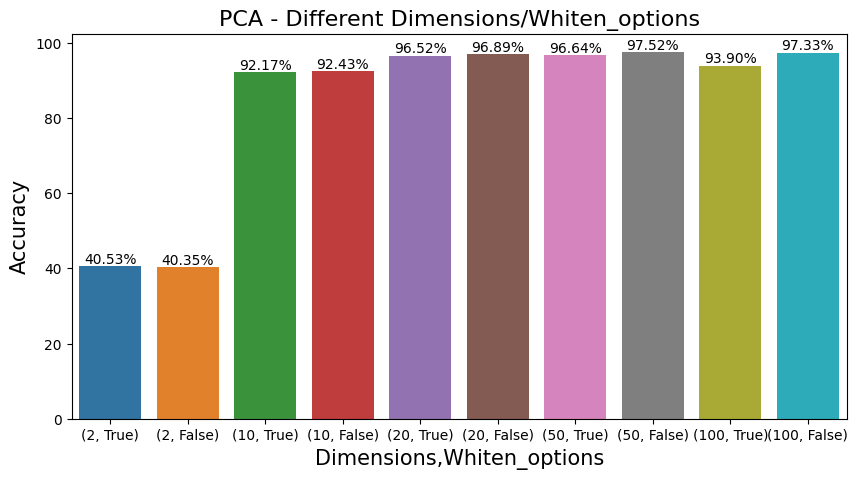

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), ax=ax)
ax.set_xlabel("Dimensions,Whiten_options", size=15)
ax.set_ylabel("Accuracy", size=15 )
ax.set_title("PCA - Different Dimensions/Whiten_options", size=16)
ax.bar_label(ax.containers[0], fmt='%.2f%%');

### T-SNE

In [148]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_X_train = tsne.fit_transform(flat_X_train)

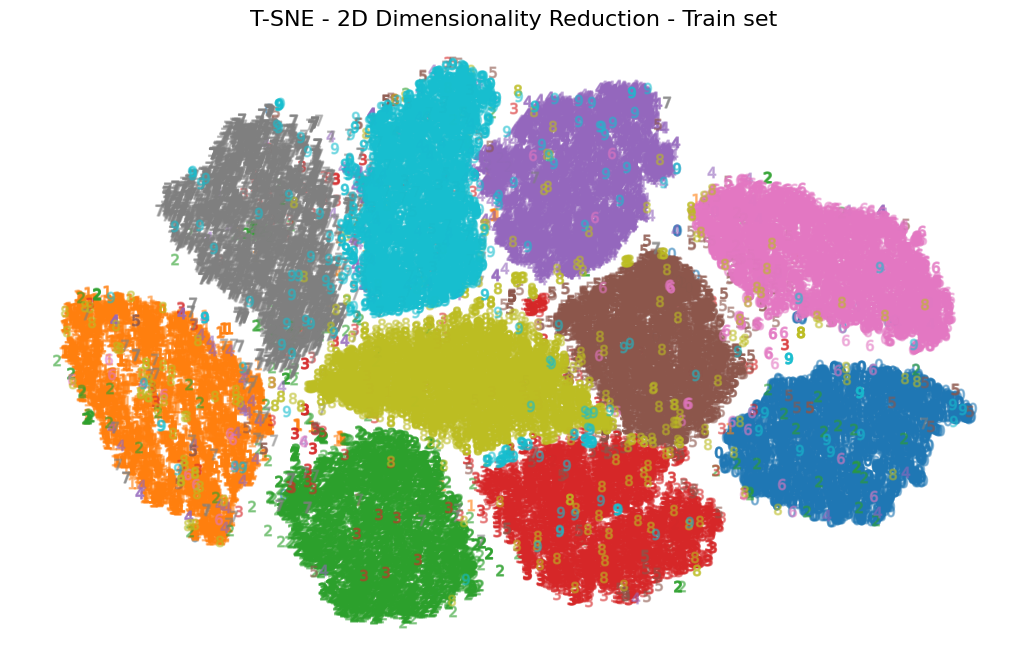

In [149]:
plot_clusters(tsne_X_train, y_train, "T-SNE - 2D Dimensionality Reduction - Train set")

In [150]:
nn = NearestNeighbors(n_neighbors=4)
nn.fit(flat_X_train)
train_neighbors = nn.kneighbors(np.squeeze(flat_X_test), 3 , return_distance=False)
tsne_X_test = tsne_X_train[train_neighbors].mean(axis=1)

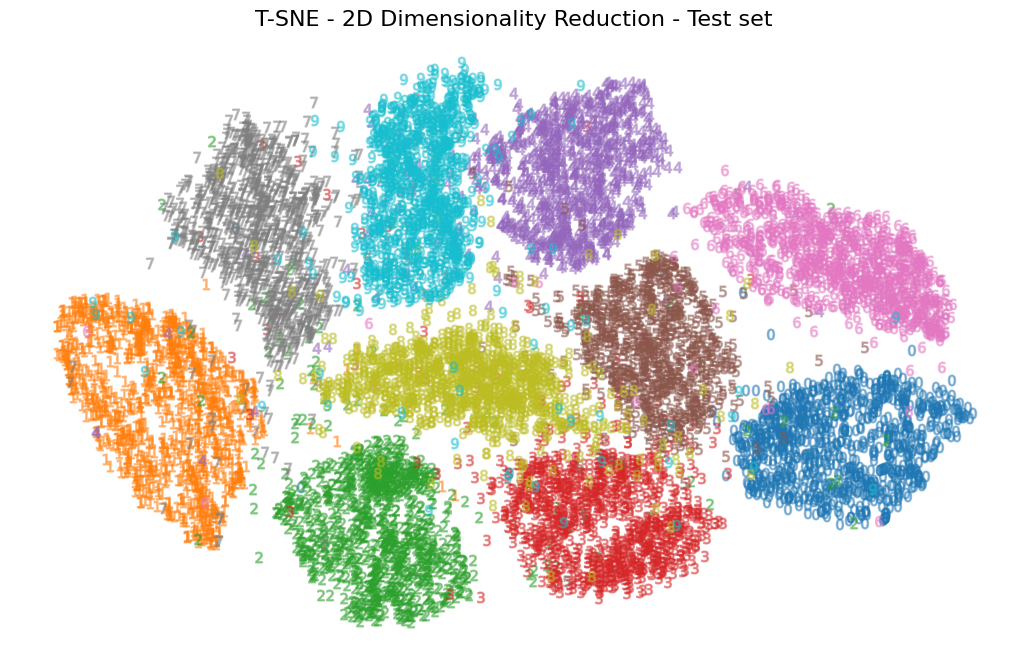

In [151]:
plot_clusters(tsne_X_test, y_test, "T-SNE - 2D Dimensionality Reduction - Test set")

In [152]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(tsne_X_train, y_train)
tsne_pred = knn.predict(tsne_X_test)
print(f'Accuracy for T-SNE after Dimensionality Reduction: {get_acc(tsne_pred, y_test):0.2%}')

Accuracy for T-SNE after Dimensionality Reduction: 94.51%


#### T-SNE - Experiment

In [153]:
results = {}
datasets = []
perplexities = [2, 5, 30, 50 ,100]
for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne_X_train = tsne.fit_transform(flat_X_train)
    datasets.append(tsne_X_train)
    nn = NearestNeighbors(n_neighbors=3)
    nn.fit(flat_X_train)
    train_neighbors = nn.kneighbors(np.squeeze(flat_X_test), 3 , return_distance=False)
    tsne_X_test = tsne_X_train[train_neighbors].mean(axis=1)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(tsne_X_train, y_train)
    tsne_pred = knn.predict(tsne_X_test)
    results[perplexity] = get_acc(tsne_pred, y_test)*100

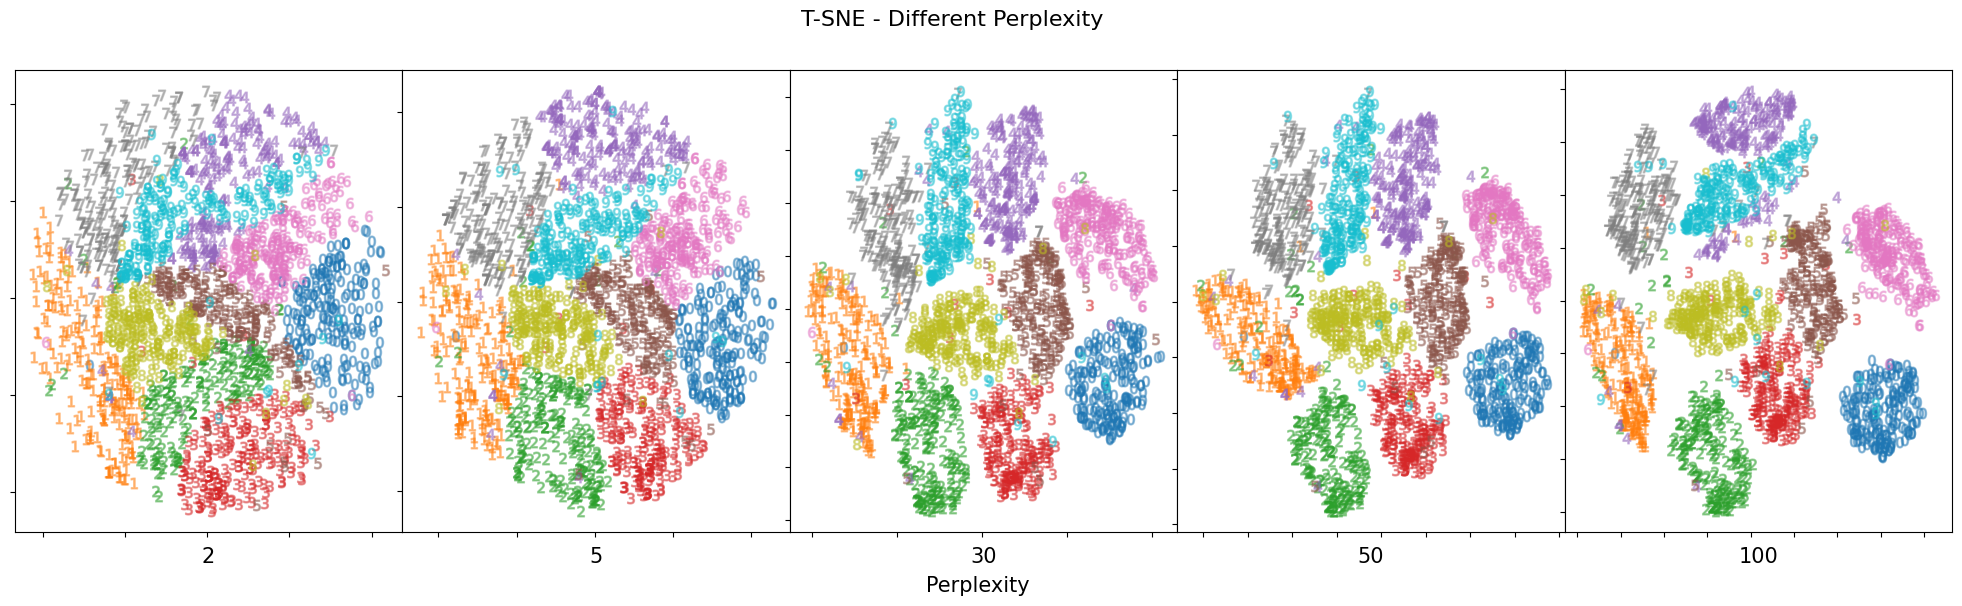

In [154]:
fig, axes = plt.subplots(1, len(datasets), figsize=(25,6))
n = 5000
for i, data in enumerate(datasets):
    for digit in range(n_classes):
        axes[i].scatter(
            *data[y_train == digit][:200].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.tab10(digit),
            alpha=0.4,
            zorder=2,
        )
    axes[i].set_yticklabels([])
    axes[i].set_xticklabels([])
    axes[i].set_xlabel(perplexities[i], size=15)
fig.text(0.51, 0.02, 'Perplexity', ha='center', va='center', size=15)
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("T-SNE - Different Perplexity", size=16);

    

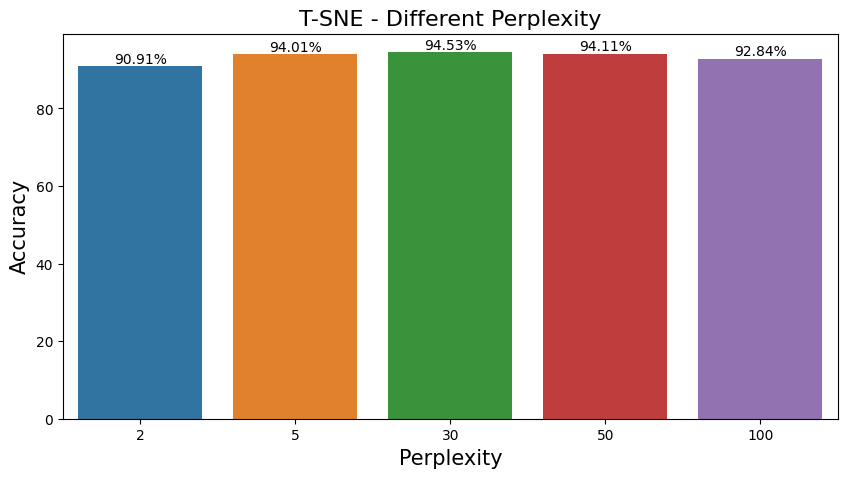

In [155]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), ax=ax)
ax.set_xlabel("Perplexity", size=15)
ax.set_ylabel("Accuracy", size=15 )
ax.set_title("T-SNE - Different Perplexity", size=16)
ax.bar_label(ax.containers[0], fmt='%.2f%%');

### Gaussian Random Projection

In [156]:
from sklearn.random_projection import GaussianRandomProjection
transformer = GaussianRandomProjection(n_components=2, random_state=42)
grp_X_train = transformer.fit_transform(flat_X_train)

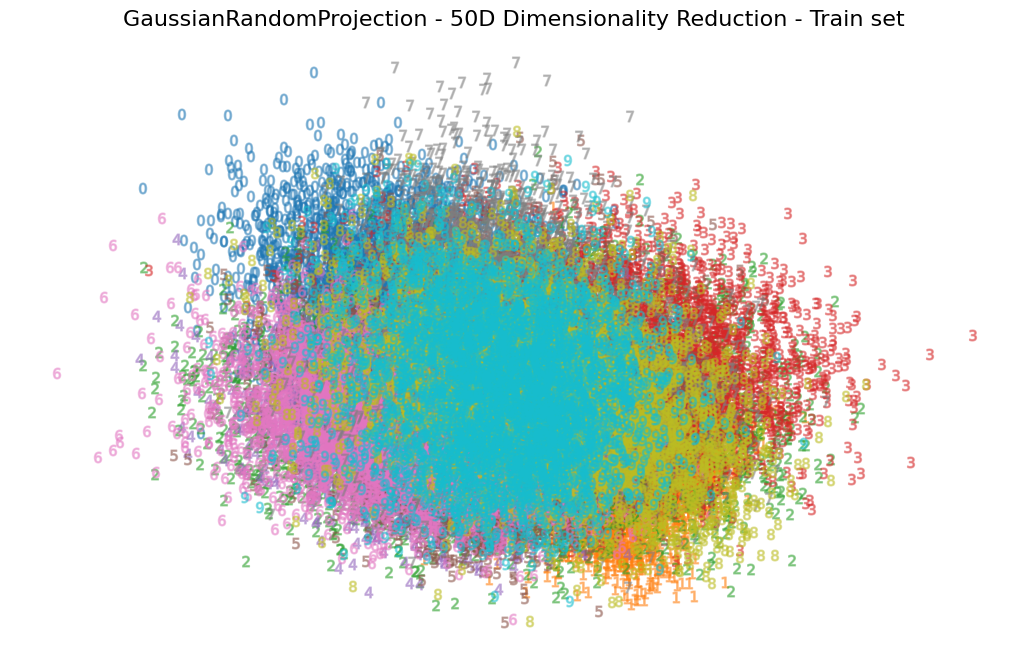

In [157]:
plot_clusters(grp_X_train, y_train, "GaussianRandomProjection - 50D Dimensionality Reduction - Train set")

In [158]:
grp_X_test = transformer.transform(flat_X_test)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(grp_X_train, y_train)
grp_y_pred = knn.predict(grp_X_test)
print(f'Accuracy for T-SNE after Dimensionality Reduction: {get_acc(grp_y_pred, y_test):0.2%}')

Accuracy for T-SNE after Dimensionality Reduction: 27.18%


#### Gaussian Random Projection - Experiment

In [159]:
n_components_lst = [2, 10, 20, 50, 100]
results  = {}
for n_components in n_components_lst:
    grp_transformer = GaussianRandomProjection(n_components=n_components, random_state=42)
    grp_X_train = grp_transformer.fit_transform(flat_X_train)
    grp_X_test = grp_transformer.transform(flat_X_test)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(grp_X_train, y_train)
    grp_pred = knn.predict(grp_X_test)
    results[n_components] = get_acc(grp_pred, y_test)*100

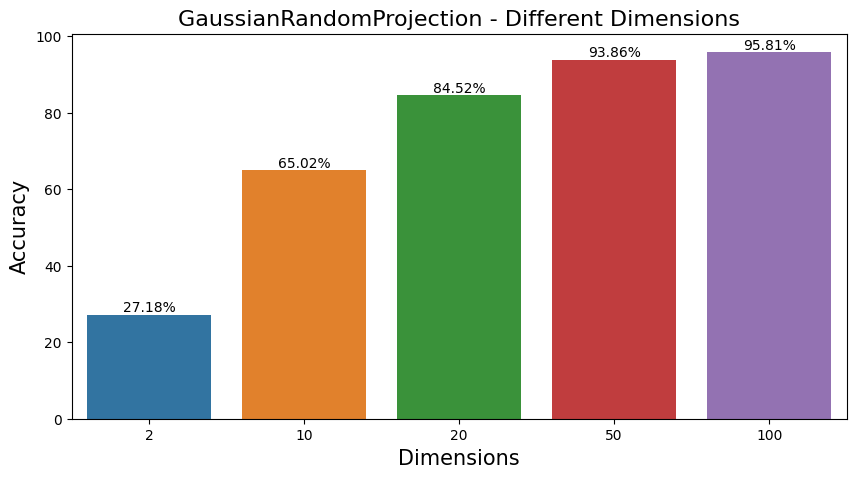

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), ax=ax)
ax.set_xlabel("Dimensions", size=15)
ax.set_ylabel("Accuracy", size=15 )
ax.set_title("GaussianRandomProjection - Different Dimensions", size=16)
ax.bar_label(ax.containers[0], fmt='%.2f%%');


## Part 3: Classification of the raw data

### Using 3NN

In [161]:
from sklearn.neighbors import KNeighborsClassifier as KNN   
knn = KNN(n_neighbors=3)
knn.fit(flat_X_train, y_train)
knn_y_pred = knn.predict(flat_X_test)

In [162]:
print(f'Accuracy for KNN on raw data: {get_acc(knn_y_pred, y_test):0.2%}')


Accuracy for KNN on raw data: 97.05%


### Using CNN

In [163]:
import torch
from torch import Tensor, optim, nn
from torch.utils.data import TensorDataset, DataLoader

In [164]:
train_dataset = TensorDataset(Tensor(X_train / 255), Tensor(y_train).long())
test_dataset = TensorDataset(Tensor(X_test / 255), Tensor(y_test).long())

In [165]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [166]:
class CNN(nn.Module):
    def __init__(self, image_size, n_hidden, n_classes) -> None:
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(image_size ** 2, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(n_hidden, n_classes)
        )

    def preprocess(self, x: torch.Tensor):
        return x.flatten(1)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.fc(x)
        
        return x

In [167]:
from collections import defaultdict

def train_model(model, criterion, optimizer: optim.Optimizer, num_epochs=5):
    train_history = defaultdict(list)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        running_loss = 0.0   # total loss of the network at each epoch
        running_corrects = 0 # number of correct predictions
        
        for sample in dataloaders['train']:
            images, labels = sample

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            y_pred = torch.max(output, dim=1)[1]
            running_corrects += (y_pred == labels).sum()

            loss.backward()
            optimizer.step()
            
        epoch_loss = running_loss / n_samples
        epoch_acc = running_corrects.double() / n_samples
        
        print('Loss: {:.4f}  |  Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 10)

        train_history['loss'].append(epoch_loss)
        train_history['accuracy'].append(epoch_acc)

    return model, train_history

In [168]:
lr = 5e-3
num_epochs = 7
model = CNN(28, 128, n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

model, train_history = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/7
Loss: 0.0045  |  Acc: 0.9148
----------
Epoch 2/7
Loss: 0.0025  |  Acc: 0.9551
----------
Epoch 3/7
Loss: 0.0022  |  Acc: 0.9614
----------
Epoch 4/7
Loss: 0.0019  |  Acc: 0.9654
----------
Epoch 5/7
Loss: 0.0017  |  Acc: 0.9696
----------
Epoch 6/7
Loss: 0.0017  |  Acc: 0.9698
----------
Epoch 7/7
Loss: 0.0015  |  Acc: 0.9728
----------


In [169]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
total = 0
correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = model.forward(images)

        _, predictions = outputs.max(1)
        total += labels.size(0)
        correct += (labels == predictions).sum()
        for i in range(len(labels)):
            confusion_matrix[labels[i], predictions[i]] += 1

model_accuracy = 100 * (correct / total)
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(test_dataset), model_accuracy))

Model accuracy on 10000 test images: 96.11%
